# UEFA Euro 2024 Penalty Visualization

This notebook visualizes penalty shots from the UEFA Euro 2024 tournament using StatsBomb event data. All data is loaded from a local CSV file (`euro2024_events.csv`).

You can use the provided functions to plot penalty shotmaps for individual players or teams.

In [16]:
import pandas as pd

# Load event data (already exported from StatsBomb)
events = pd.read_csv('../data/euro2024_shots.csv')

# Extract shots dataframe
shots_euro = events[events['type'] == 'Shot'].copy()
penalties  = events[events['shot_type'] == 'Penalty'].copy()

## Penalty Visualization Functions

The following functions allow you to plot penalty shotmaps and analyze penalties by player or team.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def draw_goal(
    *,
    theme: str = "green",              
    figsize=(12, 6),
    depth_scale: float = 0.2,         # meters -> plot units (vertical scaling)
    width_scale: float = 3.0,         # how many goal widths to show horizontally
    draw_net: bool = True,
    net_spacing: float = 0.35,
    net_alpha: float = 0.18,
    show_penalty_spot: bool = True,
    show_six_yard_box: bool = True,
    show_penalty_area: bool = True,
    penalty_spot_distance: float = 11.0, 
    six_yard_depth: float = 5.5,          
    penalty_area_depth: float = 16.5,     
    title: str | None = "Penalty Area View",
):
    """
    Zoomed penalty view where the goal is the main feature.
    - Vertical axis compressed by depth_scale.
    - Horizontal axis is scaled relative to the goal's width.
    """
    # ---------- Theme ----------
    t = theme.lower()
    if t == "white":
        PITCH_BG, LINE, NET, TEXT = "#f7f7f7", "#333333", "#aaaaaa", "#111111"
    elif t == "black":
        PITCH_BG, LINE, NET, TEXT = "#000000", "#e6e6e6", "#e6e6e6", "#e6e6e6"
    else:  # green
        PITCH_BG, LINE, NET, TEXT = "#2d5e2e", "white", "white", "black"

    # ---------- Geometry ----------
    GOAL_Y_MIN, GOAL_Y_MAX = 36.0, 44.0
    GOAL_CENTER_Y, GOAL_Z_MAX = 40.0, 2.67
    GOAL_WIDTH = GOAL_Y_MAX - GOAL_Y_MIN  # 8 SB units (~7.32m)

    # Boxes in SB units
    SIX_LEFT, SIX_RIGHT = 30.0, 50.0
    PEN_LEFT, PEN_RIGHT = 18.0, 62.0

    # Vertical compression
    def z_m(d_m): 
        return -d_m * depth_scale
    z_six = z_m(six_yard_depth)
    z_pen = z_m(penalty_area_depth)
    z_spot = z_m(penalty_spot_distance)

    # Horizontal view scaled to goal width
    span = GOAL_WIDTH * width_scale / 2
    x_left = GOAL_CENTER_Y - span
    x_right = GOAL_CENTER_Y + span

    # ---------- Figure ----------
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(PITCH_BG)
    ax.set_facecolor(PITCH_BG)
    lw = 1.6

    # Goal line
    ax.plot([x_left, x_right], [0, 0], color=LINE, lw=lw, zorder=2)

    # Goal frame
    goal_rect = Rectangle((GOAL_Y_MIN, 0), GOAL_WIDTH, GOAL_Z_MAX,
                          fill=False, linewidth=3, edgecolor=LINE, zorder=4)
    ax.add_patch(goal_rect)

    # Net
    if draw_net:
        for y in np.arange(GOAL_Y_MIN + net_spacing, GOAL_Y_MAX, net_spacing):
            ax.plot([y, y], [0, GOAL_Z_MAX], lw=0.8, color=NET, alpha=net_alpha, zorder=1)
        for z in np.arange(net_spacing, GOAL_Z_MAX, net_spacing):
            ax.plot([GOAL_Y_MIN, GOAL_Y_MAX], [z, z], lw=0.8, color=NET, alpha=net_alpha, zorder=1)

    # 6-yard box (only draw if within cropped view)
    if show_six_yard_box:
        ax.plot([SIX_LEFT, SIX_LEFT],   [0, z_six], color=LINE, lw=lw, zorder=3)
        ax.plot([SIX_RIGHT, SIX_RIGHT], [0, z_six], color=LINE, lw=lw, zorder=3)
        ax.plot([SIX_LEFT, SIX_RIGHT],  [z_six, z_six], color=LINE, lw=lw, zorder=3)

    # 18-yard box
    if show_penalty_area:
        ax.plot([PEN_LEFT, PEN_LEFT],   [0, z_pen], color=LINE, lw=lw, zorder=2)
        ax.plot([PEN_RIGHT, PEN_RIGHT], [0, z_pen], color=LINE, lw=lw, zorder=2)
        ax.plot([PEN_LEFT, PEN_RIGHT],  [z_pen, z_pen], color=LINE, lw=lw, zorder=2)

    # Penalty spot
    if show_penalty_spot:
        ax.plot([GOAL_CENTER_Y - 0.14, GOAL_CENTER_Y + 0.14],
                [z_spot, z_spot], color=LINE, lw=3, solid_capstyle='round', zorder=4)

    # Cosmetics
    ax.set_xlim(x_left, x_right)
    ax.set_ylim(z_pen - 0.5, GOAL_Z_MAX + 0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    if title:
        ax.set_title(title, color=TEXT, pad=12, fontsize=16, fontweight='bold')

    plt.tight_layout()
    return fig, ax

def plot_shot_locations(
    shots_df: pd.DataFrame,
    *,
    outcome_col: str = 'shot_outcome',
    jitter: float = 0.08,
    palette: str = 'neutral',  # 'vibrant', 'neutral', 'classic'
    **kwargs
):
    """
    Draws the goal using draw_goal and plots penalty locations on it,
    differentiating between regular play and shootouts, with styled KPIs.
    
    Args:
        palette (str): The color scheme for goals/misses.
            - 'vibrant': Blue for goals, orange for misses.
            - 'neutral': Dark gray for goals, light gray for misses.
            - 'classic': Green for goals, red for misses.
    """
    # 1. Draw the base goal visualization
    fig, ax = draw_goal(**kwargs)

    # 2. Prepare the penalty data
    penalties = shots_df.copy()  # Assume input is already filtered to penalties
    if penalties.empty:
        print("No penalty data to plot.")
        plt.show()
        return

    # Robustly extract end_x, end_y, end_z from shot_end_location
    def extract_xyz(val):
        # Handles both list-like and stringified lists
        if isinstance(val, (list, tuple)) and len(val) == 3:
            return val
        if isinstance(val, str):
            try:
                arr = eval(val)
                if isinstance(arr, (list, tuple)) and len(arr) == 3:
                    return arr
            except Exception:
                pass
        return [np.nan, np.nan, np.nan]

    xyz = penalties['shot_end_location'].apply(extract_xyz).tolist()
    penalties[['end_x', 'end_y', 'end_z']] = pd.DataFrame(xyz, index=penalties.index)
    penalties['is_goal'] = penalties[outcome_col].astype(str).eq('Goal')

    # 3. Define colors, fonts, and plot points based on palette
    if palette == 'vibrant':
        GOAL_COLOR = "#1f77b4"  # Blue
        MISS_COLOR = "#ff7f0e"  # Orange
    elif palette == 'classic':
        GOAL_COLOR = "#2ca02c"  # Green
        MISS_COLOR = "#d62728"  # Red
    else:  # 'neutral' is the default
        GOAL_COLOR = "#222222"  # Dark Gray
        MISS_COLOR = "#bbbbbb"  # Light Gray
    
    theme = kwargs.get("theme", "green")
    edge_color = "#333333" if theme == "white" else "black"
    text_color = "#111111" if theme == "white" else "white"
    legend_face = "#ffffff" if theme == "white" else "#dce7d1"
    if theme == "green":
        text_color = "black"

    # --- Use a unique font for all text elements ---
    font_props = {'family': 'DejaVu Sans Mono', 'weight': 'bold'}
    ax.set_title(kwargs.get("title", ""), color=text_color, pad=15, fontsize=18, **font_props)

    for _, row in penalties.iterrows():
        y = row['end_y'] + np.random.uniform(-jitter, jitter)
        z = row['end_z'] + np.random.uniform(-jitter, jitter)
        color = GOAL_COLOR if row['is_goal'] else MISS_COLOR
        marker = '^' if row['period'] != 5 else 'o'
        
        ax.scatter(
            y, z, s=120, alpha=0.9, facecolors=color, 
            edgecolors=edge_color, linewidth=1.2, zorder=5, marker=marker
        )

    # 4. Add a custom legend with the unique font
    legend_handles = [
        Line2D([0], [0], marker='^', linestyle='None', markersize=11,
               markerfacecolor=GOAL_COLOR, markeredgecolor=edge_color, label='Goal (Regular Play)'),
        Line2D([0], [0], marker='^', linestyle='None', markersize=11,
               markerfacecolor=MISS_COLOR, markeredgecolor=edge_color, label='No Goal (Regular Play)'),
        Line2D([0], [0], marker='o', linestyle='None', markersize=11,
               markerfacecolor=GOAL_COLOR, markeredgecolor=edge_color, label='Goal (Shootout)'),
        Line2D([0], [0], marker='o', linestyle='None', markersize=11,
               markerfacecolor=MISS_COLOR, markeredgecolor=edge_color, label='No Goal (Shootout)'),
    ]
    leg = ax.legend(handles=legend_handles, loc='upper left', frameon=True, fontsize=10)
    leg.get_frame().set_facecolor(legend_face)
    leg.get_frame().set_edgecolor(edge_color)
    for txt in leg.get_texts():
        txt.set_fontproperties(font_props)
        txt.set_color(text_color)

    # 5. Calculate and display structured KPIs on the right
    total = len(penalties)
    goals = int(penalties['is_goal'].sum())
    not_goals = total - goals
    goal_rate = 100 * goals / total if total else 0
    
    miss_types = penalties.loc[~penalties['is_goal'], outcome_col].value_counts().sort_index()
    
    body_part_counts = penalties['shot_body_part'].value_counts()
    right_foot = int(body_part_counts.get('Right Foot', 0))
    left_foot  = int(body_part_counts.get('Left Foot', 0))
    
    shootout_count = int((penalties['period'] == 5).sum())
    regular_count = total - shootout_count

    # Get plot coordinates for positioning
    x_right = ax.get_xlim()[1]
    y_top = ax.get_ylim()[1]
    
    # Position the structured KPI block with left alignment
    kx = 44.6  # Start text to the right of the goal
    ky = y_top + 0.1
    
    # --- Main Summary ---
    ax.text(kx, ky, f"{total} Total Penalties", ha='left', va='top', fontsize=14, color=text_color, **font_props)
    ky -= 0.4
    ax.text(kx, ky, f"{goals} Scored ({goal_rate:.1f}%)", ha='left', va='top', fontsize=13, color=GOAL_COLOR, **font_props)
    ky -= 0.4
    ax.text(kx, ky, f"{not_goals} Missed/Saved", ha='left', va='top', fontsize=13, color=MISS_COLOR, **font_props)
    
    # --- Miss Breakdown ---
    ky -= 0.35
    for miss_type, count in miss_types.items():
        ax.text(kx + 0.5, ky, f"• {count} {miss_type}", color=MISS_COLOR, ha='left', va='top', fontsize=12, **font_props)
        ky -= 0.3
    
    # --- Details Section ---
    ky -= 0.3
    ax.text(kx, ky, "Details", ha='left', va='top', fontsize=13, color=text_color, **font_props)
    ky -= 0.30

    # Align the '|' separator by padding the first part of the string
    part1_reg = f"Regular Play: {regular_count}"
    part1_foot = f"Right Foot: {right_foot}"
    max_len = max(len(part1_reg), len(part1_foot))

    line1 = f"{part1_reg:<{max_len}} | Shootout: {shootout_count}"
    line2 = f"{part1_foot:<{max_len}} | Left Foot: {left_foot}"

    ax.text(kx, ky, line1, ha='left', va='top', fontsize=12, color=text_color, **font_props)
    ky -= 0.3
    ax.text(kx, ky, line2, ha='left', va='top', fontsize=12, color=text_color, **font_props)

    plt.show()

def plot_penalties(
    shots_df: pd.DataFrame,
    *,
    player_name: str | None = None,
    team_name: str | None = None,
    **kwargs
):
    """
    Filters penalties for a specific player or team and plots them
    using the main plot_shot_locations function.
    """
    # Always filter from the full events dataframe, not just shots
    penalties_df = shots_df.copy()  # shots_df should be the full penalties dataframe

    if player_name:
        filtered_df = penalties_df[penalties_df['player'] == player_name].copy()
        title = f"Penalty Analysis for {player_name}"
    elif team_name:
        filtered_df = penalties_df[penalties_df['team'] == team_name].copy()
        title = f"Penalty Analysis for {team_name}"
    else:
        print("Please provide a player_name or team_name to filter by.")
        return

    if filtered_df.empty:
        filter_type = "player" if player_name else "team"
        filter_value = player_name or team_name
        print(f"No penalty data found for {filter_type}: {filter_value}")
        return

    kwargs['title'] = title
    plot_shot_locations(filtered_df, **kwargs)

## Example Usage

Plot penalties for a specific player or team:

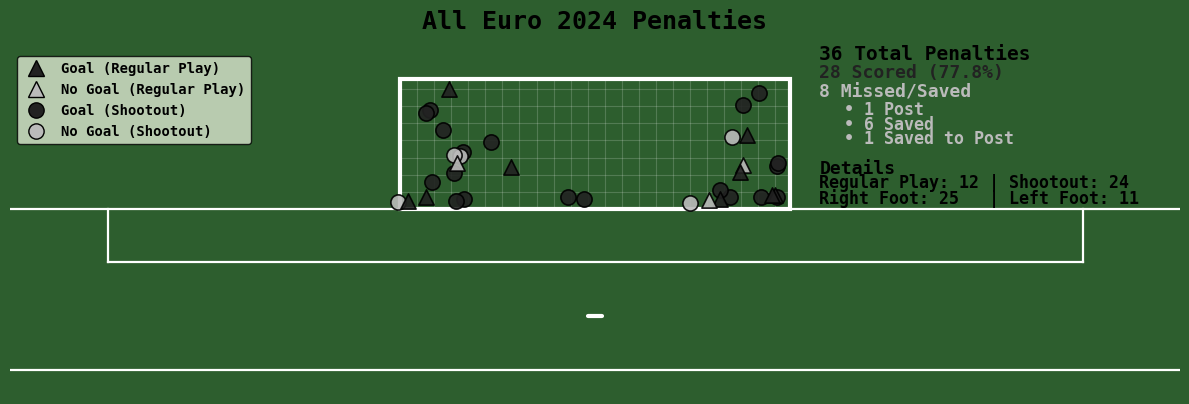

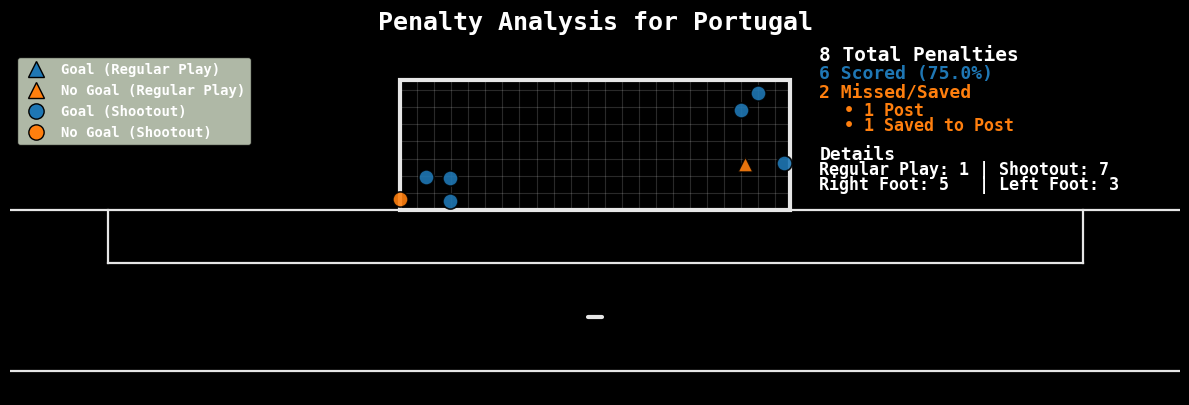

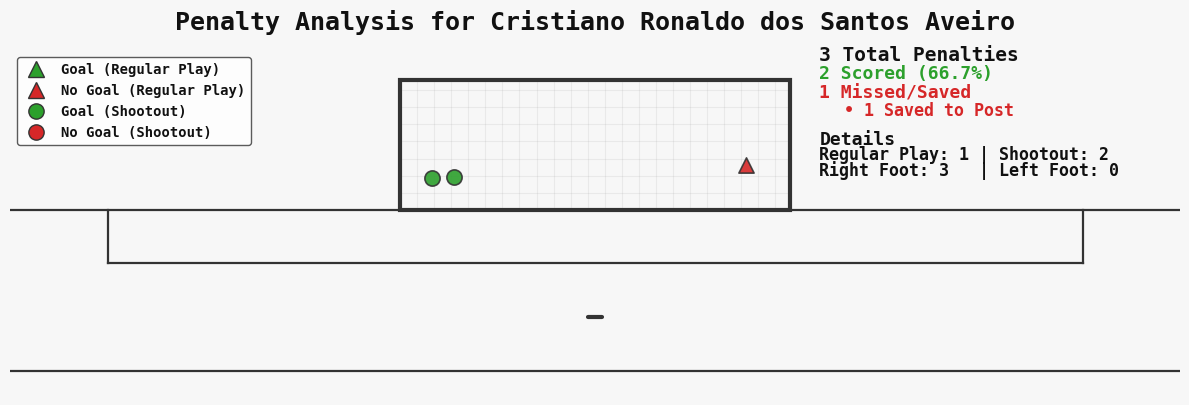

In [28]:
# Plot all penalties in the tournament
plot_shot_locations(
    penalties,
    theme="green",
    palette="neutral",
    title="All Euro 2024 Penalties"
)

# Plot penalties for a specific team
plot_penalties(
    penalties,
    team_name="Portugal",
    theme="black",
    palette="vibrant"
)

# Plot penalties for a specific player
plot_penalties(
    penalties,
    player_name="Cristiano Ronaldo dos Santos Aveiro",
    theme="white",
    palette="classic"
)